In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pycbc
import os, time, h5py
from IPython.display import display, clear_output

In [2]:
sample_rate = 2048#4096
duration = 6.
dt=1./sample_rate

f0 = 20.
f_low = 20.
f_high =  2048.
df = 1.
m1_min = 1.
m1_max = 99.
m2_min = m1_min
m2_max = m1_max
max_total_m = 100.
max_spin = 0.99

min_match = 0.97
filter_cutoff = 'SchwarzISCO'
psd_model = 'aLIGODesignSensitivityP1200087'

outfile='template_bank.xml'
template_file='templates'
signal_file='signal'
noise_file='noise'

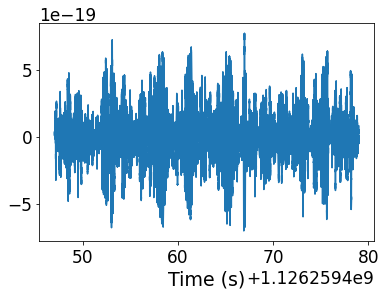

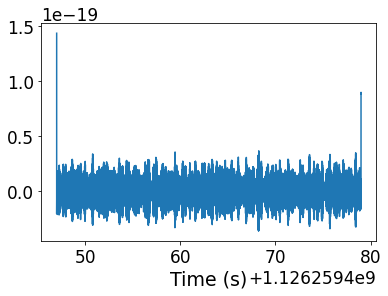

In [3]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW150914")
strain = merger.strain('H1')
plt.plot(strain.sample_times,strain)
plt.xlabel('Time (s)')
plt.show()
strain = resample_to_delta_t(highpass(strain, f_low), dt)
plt.plot(strain.sample_times,strain)
plt.xlabel('Time (s)')

plt.show()

In [6]:
print(strain.sample_times[int(len(strain.sample_times)/2)])

1126259463.0


In [ ]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
#conditioned = strain.crop(5, 5)
conditioned = strain.crop(2, 2)
#noise = strain.crop(28, 0)
psd = conditioned.psd(1)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(sample_rate),
                                  low_frequency_cutoff=f_low)

#plt.figure(figsize=[10, 4])
#plt.plot(noise.sample_times, noise)
#plt.xlabel('Time (s)')
#plt.show()

In [ ]:
plt.figure(figsize=[10, 4])
plt.plot(conditioned.sample_times, conditioned)
plt.xlabel('Time (s)')
plt.show()

In [ ]:
plt.loglog(psd.sample_frequencies, psd)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.xlim(f_low, f_high)
plt.show()

In [ ]:
datafreq = np.fft.fftfreq(len(conditioned))*sample_rate
psd_ = np.interp(datafreq, np.array(psd.sample_frequencies), np.array(psd))
np.save('psd',psd_)

In [ ]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import make_frequency_series
from pycbc.types import TimeSeries, FrequencySeries

templates = []
hps= []
hps_f= []

if True:
    
    M = int(2**(9))

    #N, M = initial_states.shape[0], initial_states.shape[1]
    bank_file = 'H1L1-BANK2HDF_SPLITBANK_BANK0_INJECTIONS-1134450017-1202400.hdf'
    full_bank = h5py.File(bank_file,'r')

    bank_size = full_bank['mass1'].size
    
    bank = {}
    bank['mass1'] = full_bank['mass1'][np.arange(bank_size)[::int(bank_size//M)]]    
    bank['mass2'] = full_bank['mass2'][np.arange(bank_size)[::int(bank_size//M)]]    
    bank['spin1z'] = full_bank['spin1z'][np.arange(bank_size)[::int(bank_size//M)]]    
    bank['spin2z'] = full_bank['spin2z'][np.arange(bank_size)[::int(bank_size//M)]]  
    bank['f_lower'] = full_bank['f_lower'][np.arange(bank_size)[::int(bank_size//M)]]
    
    templates = []

    for i in np.arange(bank_size)[::int(bank_size//M)]:
        print(float(full_bank['mass1'][i]),float(full_bank['mass2'][i]))
        hp, hc = get_td_waveform(approximant="IMRPhenomPv3",
                            mass1=float(full_bank['mass1'][i]),
                            mass2=float(full_bank['mass2'][i]),
                            spin1z=float(full_bank['spin1z'][i]),
                            spin2z=float(full_bank['spin2z'][i]),
                            delta_t=conditioned.delta_t,
                            f_lower=float(full_bank['f_lower'][i]))
            
        hp.resize(len(conditioned))
        template = hp.cyclic_time_shift(hp.start_time)
        #waveform[0].resize(len(conditioned))
        #waveform[0] = waveform[0].cyclic_time_shift(waveform[0].start_time)
        #hps.append(waveform[0])
        hps_f.append(np.array(make_frequency_series(TimeSeries(template,delta_t=dt))))
        #fhp = np.fft.fft(np.array(waveform[0]))
        #sq = np.abs((fhp * fhp.conjugate() / psd_).sum())
        #norm = 4. / np.sqrt(4. * np.abs(datafreq[1]-datafreq[0]) * sq)
        #templates.append((fhp/psd_)*norm)
    #templates = np.array(templates)
    #np.save(template_file,templates)
    print('Done!')

In [ ]:
def my_matched_filter(data, template):
    return data*template.conjugate()

In [ ]:
signal = make_frequency_series(TimeSeries(np.array(conditioned), delta_t=dt))
np.save(signal_file,signal)
df = np.abs(datafreq[1]-datafreq[0])
print(df)

In [ ]:
import pycbc.noise
import pycbc.psd
psd_noise = pycbc.psd.aLIGOZeroDetHighPower(len(psd), df, f_low)

noise_ = pycbc.noise.noise_from_psd(len(strain), strain.delta_t, psd_noise)
noise_ = resample_to_delta_t(highpass(noise_, f_low), dt)
noise_t = noise_.crop(2, 2)
noise = make_frequency_series(TimeSeries(np.array(noise_t), delta_t=dt))
np.save(noise_file,noise)

plt.plot(noise_t)
plt.xlabel('Time (s)')
plt.show()

In [ ]:
SNR_threshold=12.

In [ ]:
from pycbc.filter import matched_filter

SNRs = []
signal_f = np.array(signal)

#for template,hp_f,hp in zip(templates,hps_f,hps):
#    template_f = np.array(make_frequency_series(TimeSeries(hp, delta_t=dt)))
for i,hp_f in enumerate(hps_f):
    #print(hp_f)
    snr_ = matched_filter(FrequencySeries(hp_f, delta_f=df), 
                                   FrequencySeries(signal_f, delta_f=df), 
                                   psd=FrequencySeries(psd_,delta_f=df))#, low_frequency_cutoff=bank['f_lower'][i])
    snr_ = snr_.crop(8, 4)
    snr = np.array(snr_)
    SNRs.append(np.max(np.abs(snr)))
    if SNRs[-1]>=SNR_threshold:
        plt.plot(snr_.sample_times, abs(snr_))
        plt.show()
    print(np.max(np.abs(snr)))
SNRs = np.array(SNRs)
print(SNRs[SNRs>SNR_threshold])

In [ ]:
%matplotlib inline
plt.scatter(bank['mass1'],bank['mass2'],marker='.',color='black')
plt.scatter(bank['mass1'][SNRs>SNR_threshold],bank['mass2'][SNRs>SNR_threshold],marker='.',color='orange')

plt.xlabel(r'$m_{1}$')
plt.ylabel(r'$m_{2}$')
plt.show()
print(bank['mass1'][SNRs>SNR_threshold],bank['mass2'][SNRs>SNR_threshold])

In [ ]:
from pycbc.filter import matched_filter

SNRs = []
signal_f = np.array(noise)

#for template,hp_f,hp in zip(templates,hps_f,hps):
#    template_f = np.array(make_frequency_series(TimeSeries(hp, delta_t=dt)))
for i,hp_f in enumerate(hps_f):
    #print(hp_f)
    snr_ = matched_filter(FrequencySeries(hp_f, delta_f=df), 
                                   FrequencySeries(signal_f, delta_f=df), 
                                   psd=FrequencySeries(psd_,delta_f=df))#, low_frequency_cutoff=bank['f_lower'][i])
    snr_ = snr_.crop(8, 4)
    snr = np.array(snr_)
    SNRs.append(np.max(np.abs(snr)))
    if SNRs[-1]>=SNR_threshold:
        plt.plot(snr_.sample_times, abs(snr_))
        plt.show()
    print(np.max(np.abs(snr)))
SNRs = np.array(SNRs)
print(SNRs[SNRs>SNR_threshold])

In [ ]:
#%matplotlib inline

#plt.scatter(waveforms.table['mass1'],waveforms.table['mass2'],marker='.',color='black')
#plt.scatter(waveforms.table['mass1'][SNRs>SNR_threshold],waveforms.table['mass2'][SNRs>SNR_threshold],marker='.',color='orange')

#plt.xlabel(r'$m_{1}$')
#plt.ylabel(r'$m_{2}$')
#plt.show()

In [ ]:
max_ind = np.argmax(SNRs)

print(bank['mass1'][max_ind],bank['mass2'][max_ind])
print(bank['spin1z'][max_ind],bank['spin2z'][max_ind])
print(bank['f_lower'][max_ind])

In [ ]:
print(SNRs)

In [ ]:
print(len(SNRs))